In [1]:
from game import *

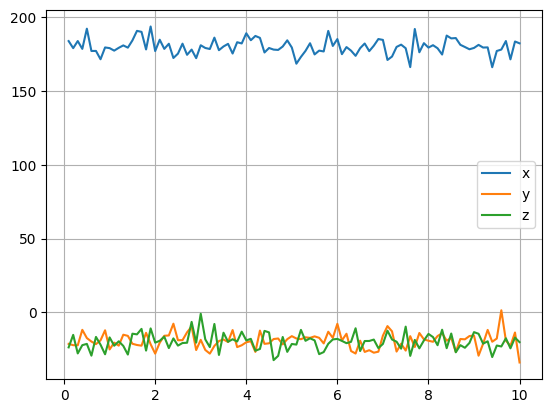

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

max_time = 10

game = GameViewer(target_xyz = np.array([180, -20, -20], dtype=int), max_time = max_time, max_target_speed = 0, step_target_distance = 40, shoot_skip = 10)
x = []
y = []
z = []
times = []
angles_xy = []
angle_xy, angle_xz = 40, -10

while game.time < max_time:
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    y.append(target_xyz[1])
    z.append(target_xyz[2])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

plt.plot(times,x, label='x')
plt.plot(times,y, label='y')
plt.plot(times,z, label='z')
#plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()

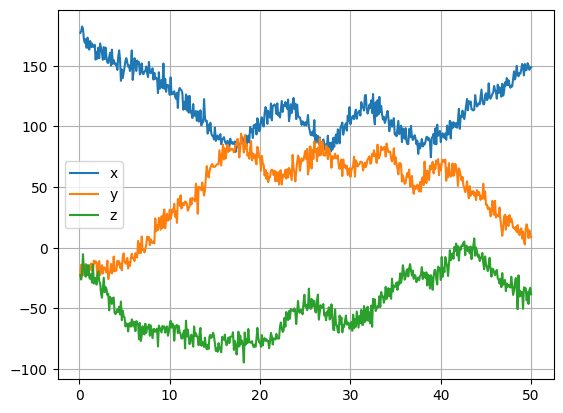

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

max_time = 50

game = GameViewer(target_xyz = np.array([180, -20, -20], dtype=int), max_time = max_time, max_target_speed = 10, step_target_distance = 40, shoot_skip = 1)
x = []
y = []
z = []
times = []
angles_xy = []
angle_xy, angle_xz = 40, -10

while game.time < max_time:
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    y.append(target_xyz[1])
    z.append(target_xyz[2])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

plt.plot(times,x, label='x')
plt.plot(times,y, label='y')
plt.plot(times,z, label='z')
#plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()

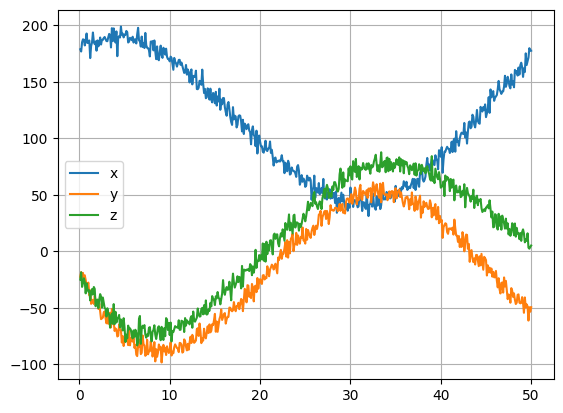

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

max_time = 50

game = GameViewer(target_xyz = np.array([180, -20, -20], dtype=int), max_time = max_time, max_target_speed = 10, step_target_distance = 400, shoot_skip = 1)
x = []
y = []
z = []
times = []
angles_xy = []
angle_xy, angle_xz = 40, -10

while game.time < max_time:
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    y.append(target_xyz[1])
    z.append(target_xyz[2])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

plt.plot(times,x, label='x')
plt.plot(times,y, label='y')
plt.plot(times,z, label='z')
#plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()

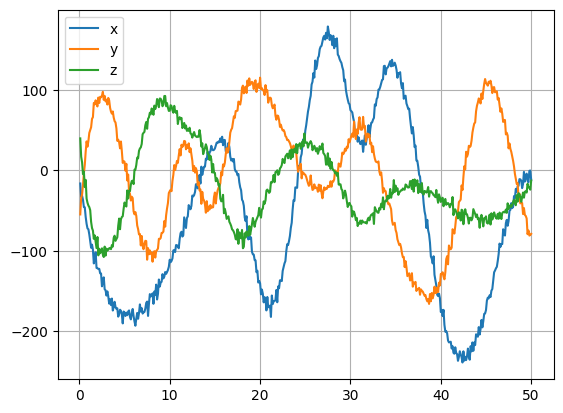

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

max_time = 50

game = GameViewer(target_xyz = None, max_time = max_time, max_target_speed = 50, step_target_distance = 400, shoot_skip = 1)
x = []
y = []
z = []
times = []
angles_xy = []
angle_xy, angle_xz = 40, -10

while game.time < max_time:
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    y.append(target_xyz[1])
    z.append(target_xyz[2])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

plt.plot(times,x, label='x')
plt.plot(times,y, label='y')
plt.plot(times,z, label='z')
#plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()

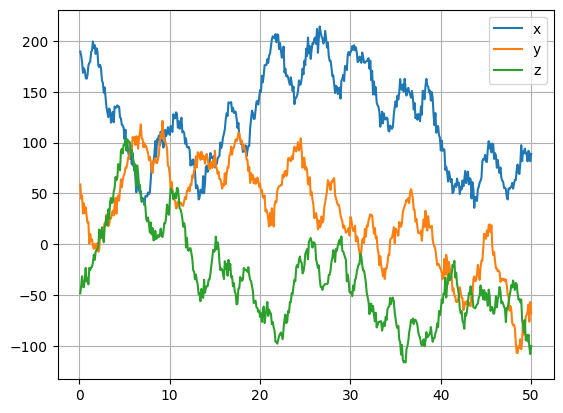

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

max_time = 50

game = GameViewer(target_xyz = None, max_time = max_time, max_target_speed = 50, step_target_distance = 40, shoot_skip = 1)
x = []
y = []
z = []
times = []
angles_xy = []
angle_xy, angle_xz = 40, -10

while game.time < max_time:
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    y.append(target_xyz[1])
    z.append(target_xyz[2])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

plt.plot(times,x, label='x')
plt.plot(times,y, label='y')
plt.plot(times,z, label='z')
#plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()